In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr, spearmanr

import os
from env import username, password, host
import env

import wrangle

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [2]:
# Create a function to acquire zillow data and save as a csv

def acquire_zillow(use_cache=True):
    ''' 
    This function acquires all necessary housing data from zillow 
    needed to better understand future pricing
    '''
    
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached csv')
        return pd.read_csv('zillow.csv')
    print('Acquiring data from SQL database')

    database_url_base = f'mysql+pymysql://{username}:{password}@{host}/zillow'
    query = '''
    SELECT bedroomcnt AS bedrooms, 
           bathroomcnt AS bathrooms, 
           calculatedfinishedsquarefeet AS sqft, 
           taxvaluedollarcnt AS tax_value, 
           yearbuilt AS yr_built,
           lotsizesquarefeet AS lot_sqft,
           fips
        FROM properties_2017
    
        JOIN propertylandusetype USING(propertylandusetypeid)
        
        JOIN predictions_2017 pr USING (parcelid)
        WHERE propertylandusedesc IN ('Single Family Residential',
        
                                      'Inferred Single Family Residential')
                              AND pr.transactiondate LIKE '2017%%';
            '''
    
    
    df = pd.read_sql(query, database_url_base)
    df.to_csv('zillow.csv', index=False)
   
    return df

In [3]:
# Use/test the acquire function
df = acquire_zillow()

Using cached csv


In [4]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,yr_built,lot_sqft,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,4506.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,12647.0,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,8432.0,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,13038.0,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,63000.0,6037.0


In [5]:

df.shape

(52441, 7)

 - Original DataFrame pulled 52,441 rows in our 7 columns.

## Clean 

In [6]:
def remove_outliers(df, k, col_list):
    ''' 
    This function remove outliers from a list of columns in a 
    dataframe and returns that dataframe.
    '''
    
    # Go through each column
    for col in col_list:
        
        # Get the quantiles
        q1, q3 = df[col].quantile([.25, .75])
        
        # Get the quantile range
        iqr = q3 - q1
        
        # Establish the upper and lower
        upper_bound = q3 + k * iqr  
        lower_bound = q1 - k * iqr   

        # Redefine the DataFrame with removed outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [7]:
def clean_zillow(df):
    '''
    This function takes in the zillow data, cleans it, and 
    returns a dataframe.
    '''
    
    # Apply a function to remove outliers
    df = remove_outliers(df, 2.7, ['bedrooms','bathrooms',
                                   'sqft', 'lot_sqft','tax_value'])
    
    # Remove more of the outliers for sqft
    df = df[(df.sqft > 500) & (df.sqft < 2500)]
    # Remove more of the outliers for tax value
    df = df[(df.tax_value > 500) & (df.tax_value < 1_000_000)]
    # Remove further outliners with no bathrooms
    df = df[(df.bathrooms >1)]
    
    #Drop rows with null values since it is only a small portion of the dataframe 
    df = df.dropna()

    # Create list of datatypes to change
    int_cols = ['bedrooms','sqft','tax_value','lot_sqft']
#     obj_cols = []
    
    # Change data types of above columns
    for col in df:
        if col in int_cols:
            df[col] = df[col].astype(int)
#         if col in obj_cols:
#             df[col] = df[col].astype(int).astype(object)
    
#     # Drop the target column
#     df = df.drop(columns='tax_value')
    
    return df

In [8]:
df = clean_zillow(df)

In [9]:
df = df.dropna()

In [10]:
df.shape

(29411, 7)

 - After dropping outliers and nulls, we are felt with 37,242 rows in our same 7 columns.

In [11]:
df.isnull().sum()

bedrooms     0
bathrooms    0
sqft         0
tax_value    0
yr_built     0
lot_sqft     0
fips         0
dtype: int64

In [12]:
# Create list of datatypes to change
int_cols = ['bedrooms','sqft', 'tax_value', 'fips', 'lot_sqft']
# obj_cols = []

# Change data types of above columns
for col in df:
    if col in int_cols:
        df[col] = df[col].astype(int)
#     if col in obj_cols:
#         df[col] = df[col].astype(int).astype(object)


In [13]:
# # Drop the target column
# df = df.drop(columns='tax_value')

In [14]:
df.fips.value_counts()

6037    17610
6059     9048
6111     2753
Name: fips, dtype: int64

In [15]:
 # Found the counties that Zach deleted... smh
df.fips = df.fips.replace({6037:'Los Angeles',
                       6059:'Orange',          
                       6111:'Ventura'})
# Rename 'fips' to 'county
df.rename(columns={'fips':'county'}, inplace = True)
df.head()

,bedrooms,bathrooms,sqft,tax_value,yr_built,lot_sqft,county
2,3,2.0,1243,564778,1962.0,8432,Orange
3,4,3.0,2376,145143,1970.0,13038,Los Angeles
8,3,2.5,1340,319668,1980.0,1199,Orange
9,3,2.5,1371,198054,2004.0,3445,Ventura
10,4,2.0,1677,528847,1981.0,5304,Orange


In [16]:
# # Encode fips column for binary answer to county
# dummy_df = pd.get_dummies(df['fips'])
# # Concatenate dummy variables onto df
# df = pd.concat([df, dummy_df], axis=1)
# # Drop the fips column
# df = df.drop(columns=['fips'])

In [17]:
# # Concatenate dummy variables onto df
# df = pd.concat([df, dummy_df], axis=1)
# # Drop the fips column
# df = df.drop(columns=['fips'])

# # Rename fips

In [18]:
# # Drop the fips column
# df = df.drop(columns=['fips'])

# df.head()

## Split

In [19]:
# Split the data
train_val, test = train_test_split(df, 
                                   train_size=0.8, 
                                   random_state = 123) 
#                                    stratify = df['tax_value'])
    
    
train, validate = train_test_split(train_val, 
                                   train_size=0.7, 
                                   random_state=123) 
#                                    stratify = train['tax_value'])

In [20]:
train.shape[0]+validate.shape[0]+test.shape[0]

29411

In [21]:
train.shape, validate.shape, test.shape

((16469, 7), (7059, 7), (5883, 7))

## Exploration

Text(0.5, 1.0, 'Rankings of Correlation to Tax Value')

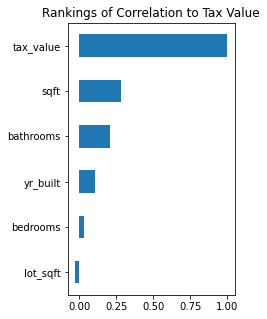

In [22]:
# Create horizontal bar chart to visualize correlation between each 
# feature and tax value
hbar_corr = df.corr()['tax_value'].sort_values().plot(kind='barh', figsize=(3,5))
plt.title('Rankings of Correlation to Tax Value')

In [23]:
# Create a correlation matrix of the above correlations
corr_matr = train.corr().reset_index()
corr_matrix = train.corr()
corr_matrix['tax_value'].sort_values(ascending = False).reset_index()

,index,tax_value
0,tax_value,1.000000
1,sqft,0.281423
2,bathrooms,0.206308
3,yr_built,0.104253
4,bedrooms,0.025478
5,lot_sqft,-0.023101


In [24]:
cont_cols = ['bedrooms', 'bathrooms', 'sqft', 'lot_sqft', 'yr_built', 'tax_value']

In [25]:
def plot_variable_pairs(df):
    # plot the columns in a pairplot
    sns.pairplot(df, kind = 'reg', corner = True, plot_kws={'line_kws':{'color':'red'}})
    plt.show()

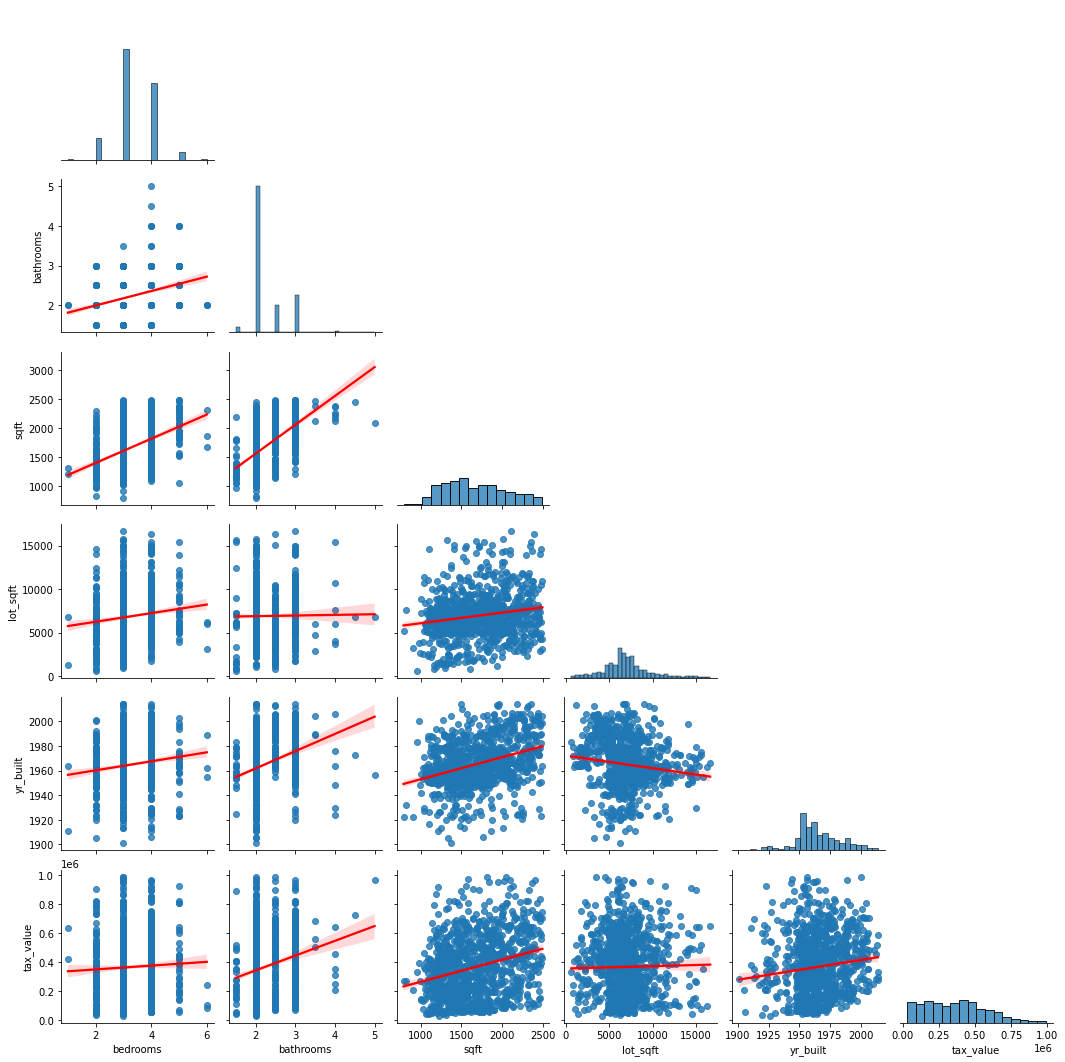

In [26]:
plot_variable_pairs(train[cont_cols].sample(1000))

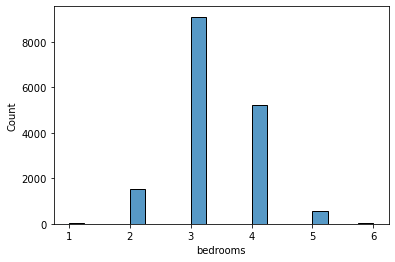

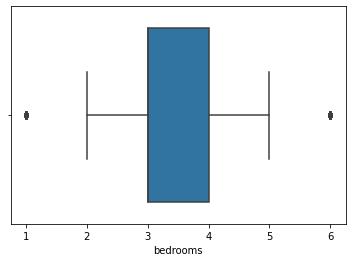

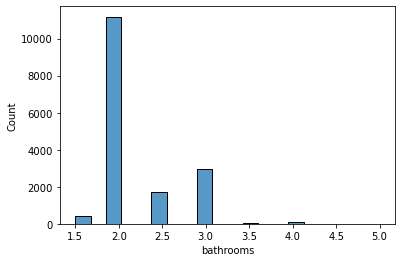

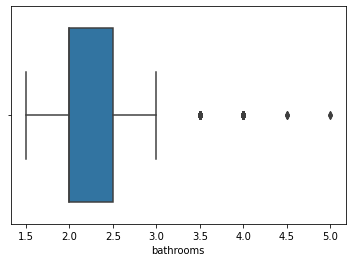

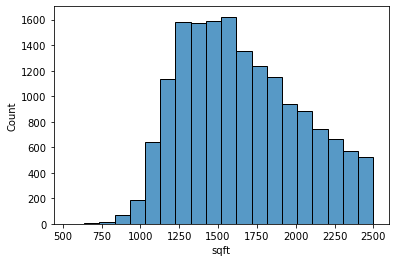

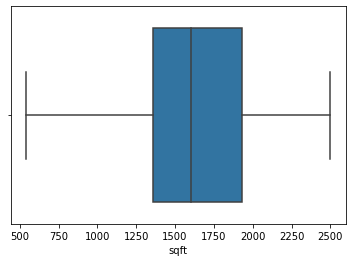

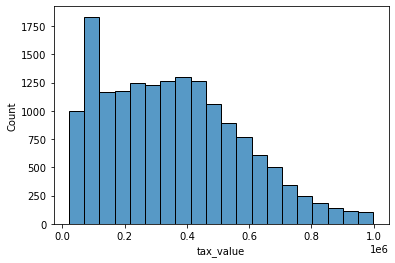

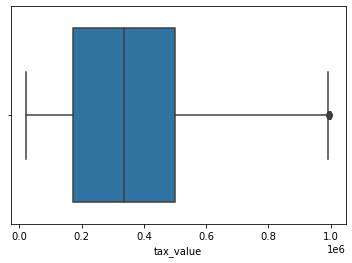

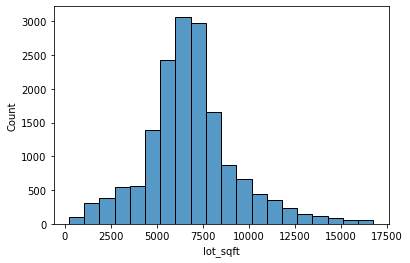

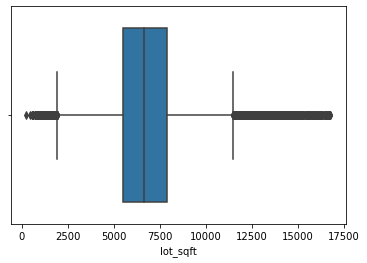

In [27]:
num_cols = [col for col in train if col in ['tax_value', 'bedrooms', 
                                            'bathrooms', 'sqft', 
                                            'lot_sqft']]
for col in num_cols:
    sns.histplot(train[col], log_scale=[False,False], bins=20)
    plt.show()
    sns.boxplot(train[col])
    plt.show()

### Exploratory Questions:

    - What county has the highest tax values?
    - Does number of bedrooms effect tax value?
    - Does number of bathrooms effect tax value?
    - Does house square footage effect tax value?
    - Does lot square footage effect tax value?


Text(0.5, 1.0, 'Property Tax Values Are Highest In Orange County Slightly Besting out Ventura County')

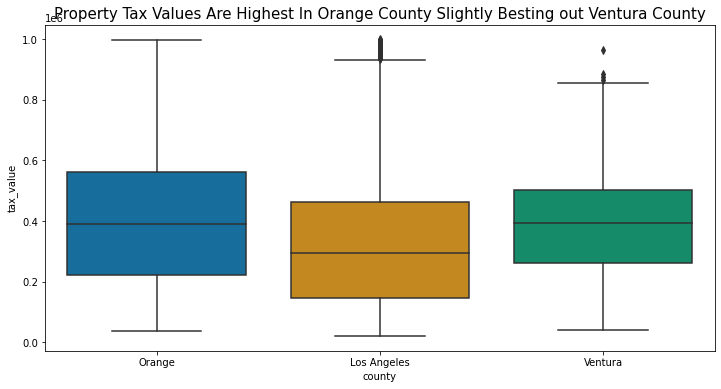

In [28]:
plt.figure(figsize=(12,6))

sns.boxplot(x='county', y='tax_value', data=train , palette='colorblind')
plt.title('Property Tax Values Are Highest In Orange County Slightly Besting out Ventura County', fontsize=15)



 #### Number of Bedrooms...

Text(6.799999999999997, 0.5, 'Tax Value in USD')

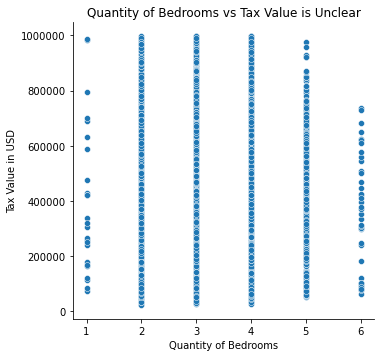

In [29]:
ax1 = sns.relplot(x ='bedrooms', y ='tax_value', data = train,
            palette = 'colorblind',kind = 'scatter')
plt.title('Quantity of Bedrooms vs Tax Value is Unclear')
plt.ticklabel_format(style = 'plain')
plt.xlabel('Quantity of Bedrooms')
plt.ylabel('Tax Value in USD')

#### Hypothesis:
 - H0: There is no linear relationship between number of bedrooms and tax value of a property.
 
 - Ha: There is a linear relationship between number of bedrooms and tax value of a property.

#### Pearson's r:

In [30]:
alpha = .05

r, p = pearson = pearsonr(train.bathrooms, train.tax_value)

if p > alpha:
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')



p-value = 0.0
The null hypothesis is rejected! 


#### Number of Bathrooms...

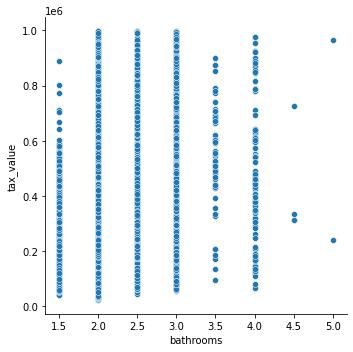

In [31]:
ax2 = sns.relplot(x ='bathrooms', 
            y ='tax_value', 
            data = train, 
            palette = 'colorblind',
            kind = 'scatter')


#### Hypothesis:
 - H0: There is no linear relationship between number of bathrooms and tax value of a property.
 
 - Ha: There is a linear relationship between number of bathrooms and tax value of a property.

#### Pearson's r:

In [32]:
alpha = .05

r, p = pearson = pearsonr(train.bedrooms, train.tax_value)

if p > alpha:
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')

p-value = 0.00108
The null hypothesis is rejected! 


#### House Square Footage...

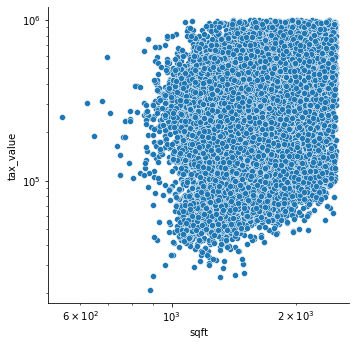

In [33]:
ax3 = sns.relplot(x ='sqft', 
            y ='tax_value', 
            data = train, 
            palette = 'colorblind',
            kind = 'scatter')

ax3.set(xscale = 'log')
ax3.set(yscale = 'log')

#### Hypothesis:
 - H0: There is no linear relationship between the square footage of  a property and it's tax value.
 
 - Ha: There is a linear relationship between the square footage of  a property and it's tax value.

#### Pearson's r:

In [34]:
alpha = .05

r, p = pearson = pearsonr(train.sqft, train.tax_value)

if p > alpha:
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')

p-value = 0.0
The null hypothesis is rejected! 


#### Lot square footage...

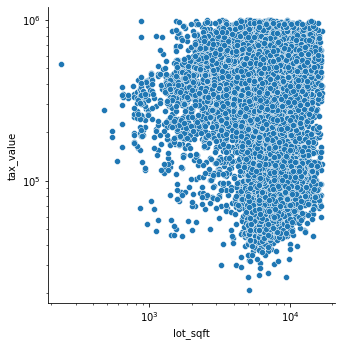

In [35]:
ax4 = sns.relplot(x ='lot_sqft', 
            y ='tax_value', 
            data = train, 
            palette = 'colorblind',
            kind = 'scatter')

ax4.set(xscale = 'log')
ax4.set(yscale = 'log')

#### Pearson's r:

In [36]:
alpha = .05

r, p = pearson = pearsonr(train.lot_sqft, train.tax_value)

if p > alpha:
    print(f'p-value = {round(p,5)}')
    print('We fail to reject the null hypothesis')
else:
    print(f'p-value = {round(p,5)}')
    print('The null hypothesis is rejected! ')

p-value = 0.00303
The null hypothesis is rejected! 


## Modeling / Feature Engineering

In [37]:
# # Establish a baseline for tax values for train and validate sets
# baseline = train.tax_value.median()
# baseline

In [38]:
# # Introduce baseline to each set
# train['baseline'] = baseline
# validate['baseline'] = baseline
# test['baseline'] = baseline
# train.head()

In [47]:
 
# Define the X and y's while dropping the target 
target = 'tax_value'
    
# split train into X (dataframe, drop target) & y (series, keep target only)
x_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
x_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
x_test = test.drop(columns=[target])
y_test = test[target]

In [48]:

# Turn y_train and y_validate into dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Calculate tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# Calculate tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# Calcualte RMSE of tax_value_pred_mean
basemean_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
basemean_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('====================================')
print('          Baseline Measures')
print('====================================')
print("RMSE using Mean\nTrain/In-Sample: ", round(basemean_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(basemean_rmse_validate, 2))
print('------------------------------------')

# Calculate RMSE of tax_value_pred_median
basemedian_rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
basemedian_rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(basemedian_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(basemedian_rmse_validate, 2))
print('------------------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The r^2 score for baseline is {round(r2_baseline, 6)}')
print('------------------------------------')

          Baseline Measures
RMSE using Mean
Train/In-Sample:  216376.39 
Validate/Out-of-Sample:  214959.83
------------------------------------
RMSE using Median
Train/In-Sample:  217217.61 
Validate/Out-of-Sample:  216126.45
------------------------------------
The r^2 score for baseline is -0.000283
------------------------------------


In [49]:
# metric_df = pd.DataFrame(data =[{
#     'model': 'Mean Baseline',
#     'RMSE_train': rmse_train,
#     'RMSE_validate': rmse_validate,
#     'r^2_score': r2_baseline}])
# metric_df

With an r^2 score of 0, we can assume that there is little to no difference between the use of either baseline.

### Scaling:

In [50]:
# Columns for scaling:
scale_cols = ['bedrooms', 'bathrooms', 'sqft', 'lot_sqft']
 

In [51]:
#Make the scaler
scaler = sklearn.preprocessing.MinMaxScaler()

In [52]:
#Fit the scaler
scaler.fit(x_train[scale_cols])

MinMaxScaler()

In [53]:
# Use the scaler
x_train_scaled = scaler.transform(x_train[scale_cols])
x_validate_scaled = scaler.transform(x_validate[scale_cols])
x_test_scaled = scaler.transform(x_test[scale_cols])

In [54]:
# Convert into a DataFrame
x_train_scaled = pd.DataFrame(x_train_scaled, columns = scale_cols)
x_validate_scaled = pd.DataFrame(x_validate_scaled, columns = scale_cols)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = scale_cols)

Verify our features' importance...

### Feature Selection:

#### K_Best

In [55]:
# # Make the model
# kbest = SelectKBest(f_regression, k=3)

# # Fit the model
# kbest.fit(x_train, y_train.tax_value)

# # Boolean mask of whether the column was selected or not. 
# feature_mask = kbest.get_support()

# # Use the model to get list of top predictive features. 
# kb_features = x_train.iloc[:,feature_mask].columns.tolist()
# print(f'kbest for predicting tax value are: {kb_features}')

#### Recursive Feature Elmination...

In [56]:
# use RFE to select top two features

# Make the things
lm = LinearRegression() 
rfe = RFE(lm, n_features_to_select=3)

# Fit the thing
rfe.fit(x_train_scaled, y_train.tax_value)

# use the thing
rfe_features = x_train_scaled.columns[rfe.support_].tolist()
print(f'rfe for predicting tax value are: {rfe_features}')

rfe for predicting tax value are: ['bedrooms', 'sqft', 'lot_sqft']


In [57]:
# Based on the following features:
features = ['bedrooms', 'bathrooms', 'sqft', 'lot_sqft']

In [58]:
# Convert y to DataFrame
y_train = pd.DataFrame(y_train)

y_validate = pd.DataFrame(y_validate)

y_test  = pd.DataFrame(y_test)

In [59]:
x_train_scaled

,bedrooms,bathrooms,sqft,lot_sqft
0,0.6,0.142857,0.435426,0.349037
1,0.4,0.142857,0.465033,0.352670
2,0.2,0.142857,0.347626,0.088168
3,0.4,0.142857,0.715671,0.851520
4,0.6,0.142857,0.538540,0.403476
...,...,...,...,...
16464,0.6,0.142857,0.497703,0.446954
16465,0.4,0.142857,0.418070,0.300533
16466,0.4,0.142857,0.336907,0.109362
16467,0.6,0.285714,0.630424,0.377801


### Models:

#### Linear Regression...

In [60]:
# Create the model
lm = LinearRegression(normalize=True)

# Fit the model 
lm.fit(x_train_scaled[features], y_train['tax_value'])

# Set predictions
y_train['tax_value_pred_lm'] = lm.predict(x_train_scaled[features])

# Evaluate RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# Predict validate 
y_validate['tax_value_pred_lm'] = lm.predict(x_validate_scaled[features])

# Evaluate RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2))


RMSE for OLS using LinearRegression
Training/In-Sample:  205381.75 
Validation/Out-of-Sample:  204022.96


#### LassoLars...

In [61]:
# Create the model
lars = LassoLars(alpha=1.0)

# Fit the model  
lars.fit(x_train_scaled[features], y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(x_train_scaled[features])

# evaluate: rmse
rmse_train2 = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(x_validate_scaled[features])

# evaluate: rmse
rmse_validate2 = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train2,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate2,2))

RMSE for Lasso + Lars
Training/In-Sample:  205381.95 
Validation/Out-of-Sample:  204021.59


#### TweedieRegressor (GLM)...

In [62]:
# Create the model
glm = TweedieRegressor(power=1, alpha=0)

#Fit the model 
glm.fit(x_train_scaled[features], y_train.tax_value)

# Predict train
y_train['tax_value_pred_glm'] = glm.predict(x_train_scaled[features])

# Evaluate: rmse
rmse_train3 = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# Predict validate
y_validate['tax_value_pred_glm'] = glm.predict(x_validate_scaled[features])

# Evaluate: rmse
rmse_validate3 = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train3,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate3,2))


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  205225.8 
Validation/Out-of-Sample:  203995.51


#### Polynomial Features...

In [63]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train_scaled[features])

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate_scaled[features])
# x_test_degree2 = pf.transform(x_test)


In [64]:
# Create the model
lm2 = LinearRegression(normalize=True)

# Fit the model 
lm2.fit(x_train_degree2, y_train.tax_value)

# Set predictions
y_train['tax_value_pred_lm2'] = lm2.predict(x_train_degree2)

# Evaluate RMSE for train
rmse_train4 = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# Predict validate 
y_validate['tax_value_pred_lm2'] = lm2.predict(x_validate_degree2)

# Evaluate RMSE for validate
rmse_validate4 = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Features using LinearRegression\nTraining/In-Sample: ", round(rmse_train4,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate4,2))


RMSE for Polynomial Features using LinearRegression
Training/In-Sample:  204488.26 
Validation/Out-of-Sample:  203465.48


### To summarize the 3 models:

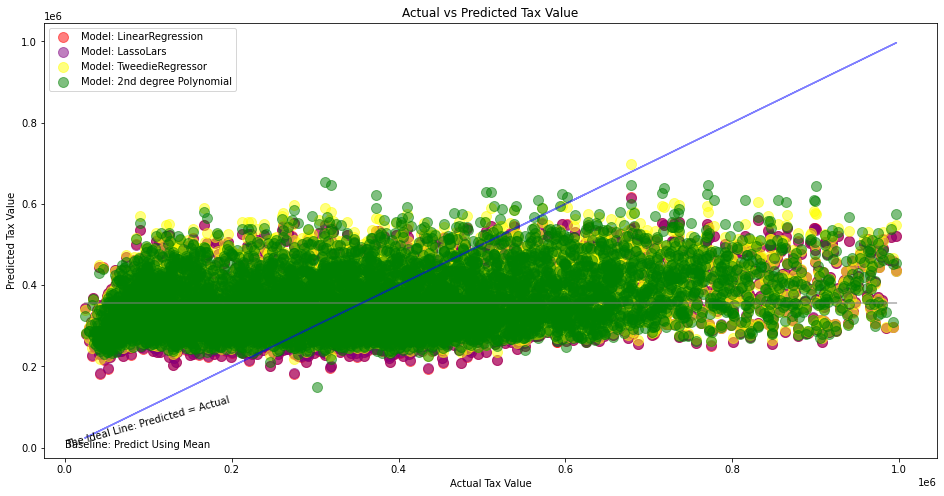

In [65]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model: LassoLars")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model: 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Actual vs Predicted Tax Value")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


In [66]:
print('===================================================')
print("RMSE for Baseline using Mean\nTrain/In-Sample: ", round(basemean_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(basemean_rmse_validate, 2))
print('===================================================')
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2))
print('===================================================')
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train2,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate2,2))
print('===================================================')
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train3,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate3,2))
print('===================================================')
print("RMSE for Polynomial Features using LinearRegression\nTraining/In-Sample: ", round(rmse_train4,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate4,2))
print('===================================================')

RMSE for Baseline using Mean
Train/In-Sample:  216376.39 
Validate/Out-of-Sample:  214959.83
RMSE for OLS using LinearRegression
Training/In-Sample:  205381.75 
Validation/Out-of-Sample:  204022.96
RMSE for Lasso + Lars
Training/In-Sample:  205381.95 
Validation/Out-of-Sample:  204021.59
RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  205225.8 
Validation/Out-of-Sample:  203995.51
RMSE for Polynomial Features using LinearRegression
Training/In-Sample:  204488.26 
Validation/Out-of-Sample:  203465.48


### Use Best Model for Test

In [67]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train_scaled[features])

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate_scaled[features])
# x_test_degree2 = pf.transform(x_test)

In [68]:
# Create the model
lm2 = LinearRegression(normalize=True)

# Fit the model 
lm2.fit(x_test_scaled[features], y_test['tax_value'])

# Set predictions
y_test['tax_value_pred_lm'] = lm2.predict(x_test_scaled[features])

# Predict validate 
y_test['tax_value_pred_lm'] = lm2.predict(x_test_scaled[features])

# Evaluate RMSE for validate
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

print("RMSE for Test Sample: ", round(rmse_test,2)) 


RMSE for Test Sample:  205322.88


### Simple Models for Selected Features

In [69]:
predictions = pd.DataFrame({
    'actual': validate.tax_value}) 

In [70]:
predictions.head()

,actual
45227,226740
40000,438235
24200,322470
27517,290865
25401,217461


In [71]:
# Set x_train
x_train = train[['bedrooms']]
# Set y_train as target
y_train = train.tax_value

# Make the model
lm = LinearRegression()
# Fit the model
lm.fit(x_train, y_train)
# Use the model
x_validate = validate[['bedrooms']]
predictions['simple_lm'] = lm.predict(x_validate)

In [72]:
print('Tax Value = {:.3f} * bedrooms + {:.3f}'.format(lm.coef_[0], lm.intercept_))

Tax Value = 7900.351 * bedrooms + 329785.517


In [73]:
# Set x_train
x_train = train[['bathrooms']]
# Set y_train as target
y_train = train.tax_value

# Make the model
lm = LinearRegression()
# Fit the model
lm.fit(x_train, y_train)
# Use the model
x_validate = validate[['bathrooms']]
predictions['simple_lm'] = lm.predict(x_validate)

In [74]:
print('Tax Value = {:.3f} * bathrooms + {:.3f}'.format(lm.coef_[0], lm.intercept_))

Tax Value = 102338.480 * bathrooms + 127005.614


In [75]:
# bathrooms = np.arange(1, 6)
# tax_value = lm.predict(bathrooms.reshape(-1, 1))
# pd.DataFrame(dict(bathrooms=bathrooms, pred_tax_value = tax_value)

In [76]:
# Set x_train
x_train = train[['sqft']]
# Set y_train as target
y_train = train.tax_value

# Make the model
lm = LinearRegression()
# Fit the model
lm.fit(x_train, y_train)
# Use the model
x_validate = validate[['sqft']]
predictions['simple_lm'] = lm.predict(x_validate)

In [77]:
print('Tax Value = {:.3f} * sqft + {:.3f}'.format(lm.coef_[0], lm.intercept_))

Tax Value = 160.661 * sqft + 89679.716


In [78]:
# Set x_train
x_train = train[['lot_sqft']]
# Set y_train as target
y_train = train.tax_value

# Make the model
lm = LinearRegression()
# Fit the model
lm.fit(x_train, y_train)
# Use the model
x_validate = validate[['lot_sqft']]
predictions['simple_lm'] = lm.predict(x_validate)

In [79]:
print('Tax Value = {:.3f} * lot sqft + {:.3f}'.format(lm.coef_[0], lm.intercept_))

Tax Value = -2.027 * lot sqft + 369727.537
